# Classifying Spam Messages


In this project, I will look at classifying spam messages using Naive Bayes.  To train the dataset, I will use a dataset with 5572 rows.  Data are classified as "ham" or "spam" messages.  The dataset used comes from the UCI Machine Learning Repository and can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).


In [16]:
import pandas as pd
import typing as t

sms_spam = pd.read_csv("SMSSpamCollection.csv", sep="\t", header=None, names=["Label", "SMS"])
print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
def percentages_ham_spam(dataset: "DataFrame") -> "DataFrame":
    return dataset["Label"].value_counts(normalize=True)

print(percentages_ham_spam(sms_spam))

ham     0.865937
spam    0.134063
Name: Label, dtype: float64


About 87% of the messages are considered "ham" messages (non-spam).

# Training the data
I am going to use 80% of the data for training and 20% for testing, with a goal of 80% accuracy.  First I will randomize the data:

In [18]:
#randomizing the dataset
random_sms_spam= sms_spam.sample(frac=1, random_state=1)

#len of data
dataset_len= len(random_sms_spam)
training_indx= round(.8*dataset_len)

#Breaking up the dataset
training_sms_spam= random_sms_spam[:training_indx].reset_index(drop=True)
test_sms_spam= random_sms_spam[training_indx:].reset_index(drop=True)

print(training_sms_spam.shape)
print(test_sms_spam.shape)


(4458, 2)
(1114, 2)


In [19]:
#percentage of spam and ham in each split dataset:

print(f"Training Dataset: \n{percentages_ham_spam(training_sms_spam)}\n")
print(f"Test Dataset: \n{percentages_ham_spam(test_sms_spam)}")


Training Dataset: 
ham     0.86541
spam    0.13459
Name: Label, dtype: float64

Test Dataset: 
ham     0.868043
spam    0.131957
Name: Label, dtype: float64


Percentages look similar between the two datasets- I wouldn't want the data to be skewed with one of the datasets having a significantly different percentage as that would mean that either the training or testing could be off.

# Data Cleaning
Below I will clean the data to remove punctuation, lower case all letters so that words can be easily compared.

In [20]:
import re

#Not using .replace() because it now warns that it will raise 
# a ValueError if regex isn't matched on next version of pds

def clean_data(series: "DataSeries") -> str:
    return series.str.replace("\W", " ").str.lower()

training_sms_spam["SMS"] = clean_data(training_sms_spam["SMS"])
test_sms_spam["SMS"]= clean_data(test_sms_spam["SMS"])

training_sms_spam.head()



<ipython-input-20-2a1f5baa5ee7>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  return series.str.replace("\W", " ").str.lower()


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


# Creating a Vocabulary

I will create a list of all of the words that are used in all messages for each dataset.


In [21]:
# function to create a list of all words
training_sms_spam["SMS"]= training_sms_spam["SMS"].str.split()

def vocab_list_gen(dataframe: "DataFrame") -> t.List[str]:
    all_words= []
    for sms_text in training_sms_spam["SMS"]:
        all_words.extend(sms_text)                    
    return list(set(all_words))

training_vocab_list= vocab_list_gen(training_sms_spam["SMS"])

#checking how many unique words we have
len(training_vocab_list)
                            

7783

# Word Counts in Each Row

Creating a dictionary of the count of each word in every row.  I will use this to create a larger dataset with row number and times they appear.

In [22]:
#creating a way to easily look up index
training_vocab_dict={word: [0]* len(training_sms_spam["SMS"]) for word in training_vocab_list}


all_word_count_dict= {}
for i, row in enumerate(training_sms_spam["SMS"]):
    for word in row:
        #for multiple empty strings
#         if training_vocab_dict.get(word, False):
        training_vocab_dict[word][i]+=1
    
word_counts= pd.DataFrame(training_vocab_dict)
print(word_counts.shape)
print(word_counts.columns)

(4458, 7783)
Index(['fml', 'persian', 'copy', 'vegas', 'mailbox', 'helping', 'yummy',
       'planning', 'dabooks', '10ppm',
       ...
       'tom', 'pics', 'bear', 'piggy', 'misfits', 'grateful', 'area',
       'cereals', 'behave', 'noline'],
      dtype='object', length=7783)


In [23]:
training_sms_spam_clean = pd.concat([training_sms_spam, word_counts], axis=1)
training_sms_spam_clean.head()

,Label,SMS,fml,persian,copy,vegas,mailbox,helping,yummy,planning,...,tom,pics,bear,piggy,misfits,grateful,area,cereals,behave,noline
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculating Naive Bayesian Propabilities

Using the following equations, with Laplace smoothing and alph.

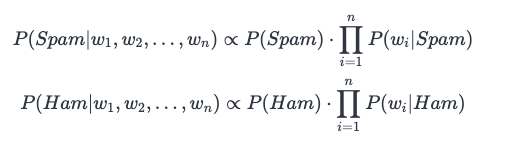


Calculating P(Spam) and P(Ham)

In [24]:
total_num_messages= word_counts.shape[1]

#adding length of each message for later calculations
training_sms_spam_clean["Message_len"]= training_sms_spam_clean["SMS"].apply(len)

spam_set= training_sms_spam_clean[training_sms_spam_clean["Label"] == "spam"]
ham_set= training_sms_spam_clean[training_sms_spam_clean["Label"] == "ham"]

count_spam= len(spam_set)
count_ham= len(ham_set)

p_spam= count_spam/total_num_messages
p_ham= count_ham/total_num_messages

spam_set.head()

,Label,SMS,fml,persian,copy,vegas,mailbox,helping,yummy,planning,...,pics,bear,piggy,misfits,grateful,area,cereals,behave,noline,Message_len
16,spam,"[freemsg, why, haven, t, you, replied, to, my,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31
18,spam,"[congrats, 2, mobile, 3g, videophones, r, your...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,26
56,spam,"[free, message, activate, your, 500, free, tex...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
60,spam,"[call, from, 08702490080, tells, u, 2, call, 0...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
61,spam,"[someone, has, conacted, our, dating, service,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25


Calculating N of spam,ham, and total vocabulary:

In [25]:
# total num words ham or spam:
total_spam_words= spam_set["Message_len"].sum()
total_ham_words= ham_set["Message_len"].sum()
total_num_words= total_spam_words+total_ham_words

# Calculating Probabilities

I am creating a function that returns a dictionary for the ham and spam sets and contains the smoothed probability that each word is in either a ham or spam message.  Setting the default alpha value for Laplace smoothing to 1.

In [26]:
def calc_props(dataframe: "DataFrame",
               n_value:int,
               alpha=1, 
               n_vocabulary= total_num_words) -> t.Dict[str, float]:
    p_dict={}
    for colname, col in dataframe.iteritems():
        if colname not in {"Label", "SMS"}:
            p_dict[colname]=(col.sum()+ alpha)/(n_value+(alpha*n_vocabulary))
            
    return p_dict
        
spam_prob= calc_props(dataframe= spam_set, n_value= total_spam_words)
ham_prob= calc_props(dataframe= ham_set, n_value= total_ham_words)
    

# The actual spam filter (finally!)


In [39]:
import re
import functools

def classify(message: str, p_spam_dict: t.Dict[str, float]= spam_prob, p_ham_dict: t.Dict[str, float]= ham_prob) -> None:
    """
    Function takes in a str, classifies it as ham or spam, prints result.
    """

    message = re.sub('\W', ' ', message)
    message = message.lower()
    
    for word in message.split():
        if not p_spam_dict.get(word, False):
            p_spam_dict[word]=1
            
        if not p_ham_dict.get(word, False):
            p_ham_dict[word]=1
        
        
    p_list_spam = [p_spam_dict[word] for word in message.split()]
    p_list_ham = [p_ham_dict[word] for word in message.split()]
    
    p_spam_given_message= functools.reduce(lambda x, y: x*y, p_list_spam)
    p_ham_given_message= functools.reduce(lambda x, y: x*y, p_list_ham)
    

    if p_ham_given_message > p_spam_given_message:
        return "ham"
    elif p_ham_given_message < p_spam_given_message:
        return "spam"
    else:
        return "Equal proabilities, have a human classify this!"
        
    

#A quick test to make sure it's reliable
print(classify("WINNER!! This is the secret code to unlock the money: C3421."))
print(classify("Sounds good, Tom, then see u there"))

spam
ham


# Testing the accuracy of the Spam Filter
I will use the test dataset to test the accuracy of the spam filter, the spam filter was expected to be more than 80% accurate.

In [42]:
correct=0
total= test_sms_spam.shape[0]

test_sms_spam["Predicted"]= test_sms_spam["SMS"].apply(classify)

for row in test_sms_spam.iterrows():
    row=row[1]
    if row["Predicted"] == row["Label"]:
        correct += 1
        
print(f"Total correct: {correct}")
print(f"Accuracy is : {correct/total}")
    

Total correct: 1079
Accuracy is : 0.9685816876122083


There was about 97% accuracy for the spam filter- much better than the predicted 80% accuracy.

# Next Steps
For next steps of the project, I would like to:
* Analyze how punctuation could allow more accurate classification of spam messages.
* Figure out if I could see anything in common between the incorrectly classified messages, and analyze why.
* Add a function that combines all of the above functions and allows generation of a spam filter with any classified group of words to make this project easily repetable.
